In [146]:
import pandas as pd
import numpy as np
import scipy
import os 

import matplotlib.pyplot as plt


from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegression 
from sklearn import ensemble 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import brier_score_loss, precision_score, recall_score,f1_score, roc_auc_score, accuracy_score 
from sklearn.metrics import confusion_matrix, roc_curve

from sklearn.preprocessing import StandardScaler 
from sklearn.feature_extraction import DictVectorizer
from sklearn.cluster import KMeans

import random

from scipy.stats import ttest_ind

In [147]:
PartDRawData = "c:\\FIP\\PartD_Prescriber_PUF_NPI_Drug_17.txt"



In [4]:
partD_pd = pd.read_csv(PartDRawData,sep="\t")


In [152]:
partD_pd.shape

(25209130, 21)

In [5]:
partD_Drug_pd1= partD_pd.loc[:,['npi','nppes_provider_city','nppes_provider_state', \
                                               'nppes_provider_last_org_name', \
                                               'nppes_provider_first_name', \
                                               'specialty_description',\
                                               'drug_name', \
                                               'generic_name',\
                                               'total_drug_cost',\
                                               'total_claim_count',\
                                               'total_day_supply']]


In [6]:
partD_pd1 = partD_Drug_pd1

In [7]:
partD_Drug_pd = partD_pd.loc[:,['npi','drug_name','total_drug_cost','total_claim_count','total_day_supply','specialty_description']]
partD_Drug_pd['npi'] = partD_Drug_pd.npi.astype(object)

In [8]:
partD_Spec_pd1= partD_pd.loc[:,['npi','specialty_description']]

In [9]:
partD_Spec_pd1.head(0)

,npi,specialty_description


In [10]:
partD_Drug_pd.head()

,npi,drug_name,total_drug_cost,total_claim_count,total_day_supply,specialty_description
0,1003000126,AMLODIPINE BESYLATE,59.21,13,390,Internal Medicine
1,1003000126,ATORVASTATIN CALCIUM,259.48,27,765,Internal Medicine
2,1003000126,CEPHALEXIN,98.99,17,123,Internal Medicine
3,1003000126,CIPROFLOXACIN HCL,120.43,12,95,Internal Medicine
4,1003000126,DOXYCYCLINE HYCLATE,300.76,17,105,Internal Medicine


In [11]:
partD_pd0= partD_pd.loc[:,['npi','nppes_provider_city','nppes_provider_state', \
                                               'nppes_provider_last_org_name', \
                                               'nppes_provider_first_name','specialty_description']]

In [12]:
partD_pd0.head()

,npi,nppes_provider_city,nppes_provider_state,nppes_provider_last_org_name,nppes_provider_first_name,specialty_description
0,1003000126,CUMBERLAND,MD,ENKESHAFI,ARDALAN,Internal Medicine
1,1003000126,CUMBERLAND,MD,ENKESHAFI,ARDALAN,Internal Medicine
2,1003000126,CUMBERLAND,MD,ENKESHAFI,ARDALAN,Internal Medicine
3,1003000126,CUMBERLAND,MD,ENKESHAFI,ARDALAN,Internal Medicine
4,1003000126,CUMBERLAND,MD,ENKESHAFI,ARDALAN,Internal Medicine


In [13]:
partD_catfpd = partD_pd0.drop_duplicates()

In [14]:
partD_catfpd.head()

,npi,nppes_provider_city,nppes_provider_state,nppes_provider_last_org_name,nppes_provider_first_name,specialty_description
0,1003000126,CUMBERLAND,MD,ENKESHAFI,ARDALAN,Internal Medicine
16,1003000142,TOLEDO,OH,KHALIL,RASHID,Anesthesiology
38,1003000167,DAYTON,NV,ESCOBAR,JULIO,Dentist
40,1003000282,NASHVILLE,TN,BLAKEMORE,ROSIE,Nurse Practitioner
42,1003000407,BROOKVILLE,PA,GIRARDI,DAVID,Family Practice


In [15]:
rename_dict = {'nppes_provider_first_name':'first_name', 'nppes_provider_last_org_name':'last_name','nppes_provider_city':'city','nppes_provider_state':'state','specialty_description':'Speciality'}
partD_catfpd = partD_catfpd.rename(columns=rename_dict)

In [16]:
partD_catfpd.head()

,npi,city,state,last_name,first_name,Speciality
0,1003000126,CUMBERLAND,MD,ENKESHAFI,ARDALAN,Internal Medicine
16,1003000142,TOLEDO,OH,KHALIL,RASHID,Anesthesiology
38,1003000167,DAYTON,NV,ESCOBAR,JULIO,Dentist
40,1003000282,NASHVILLE,TN,BLAKEMORE,ROSIE,Nurse Practitioner
42,1003000407,BROOKVILLE,PA,GIRARDI,DAVID,Family Practice


In [17]:
group_cols = ['npi']

agg_dict = {'total_drug_cost':['sum','mean','max'], \
           'total_claim_count':['sum','mean','max'],\
           'total_day_supply':['sum','mean','max']}



partD_pd2 = partD_pd1.groupby(group_cols).agg(agg_dict).astype(float)


In [18]:
partD_pd2.head(-10)

total_drug_cost                          total_claim_count  \
                       sum          mean        max               sum   
npi                                                                     
1003000126        12374.60    773.412500    9326.11             385.0   
1003000142       113868.77   5175.853182   52305.09            1846.0   
1003000167          151.75     75.875000      89.80              38.0   
1003000282          659.99    329.995000     383.12              54.0   
1003000407        73501.23   1204.938197   12322.78            2286.0   
...                    ...           ...        ...               ...   
1992998736        21715.30    603.202778    5140.46             729.0   
1992998819         1850.33   1850.330000    1850.33              23.0   
1992998926       981344.44  65422.962667  324463.75             377.0   
1992999031      2317795.96  60994.630526  731701.81            1453.0   
1992999122       689229.13   3961.086954   45476.25           12354.0   

                             total_day_supply                        
                 mean    max              sum         mean      max  
npi                                                                  
1003000126  24.062500   52.0           8053.0   503.312500   1530.0  
1003000142  83.909091  338.0          55569.0  2525.863636  11835.0  
1003000167  19.000000   24.0            157.0    78.500000    122.0  
1003000282  27.000000   32.0           1472.0   736.000000    852.0  
1003000407  37.475410  241.0          41901.0   686.901639   2369.0  
...               ...    ...              ...          ...      ...  
1992998736  20.250000   51.0          43230.0  1200.833333   3600.0  
1992998819  23.000000   23.0            187.0   187.000000    187.0  
1992998926  25.133333  109.0          24287.0  1619.133333   9810.0  
1992999031  38.236842  223.0          50619.0  1332.078947  12858.0  
1992999122  71.000000  741.0         729260.0  4191.149425  55591.0  

[917999 rows x 9 columns]

In [19]:
level0 = partD_pd2.columns.get_level_values(0)
level1 = partD_pd2.columns.get_level_values(1)
partD_pd2.columns = level0 + '_' + level1
partD_fpd = partD_pd2.reset_index()

In [20]:
partD_fpd.head()

,npi,total_drug_cost_sum,total_drug_cost_mean,total_drug_cost_max,total_claim_count_sum,total_claim_count_mean,total_claim_count_max,total_day_supply_sum,total_day_supply_mean,total_day_supply_max
0,1003000126,12374.60,773.412500,9326.11,385.0,24.062500,52.0,8053.0,503.312500,1530.0
1,1003000142,113868.77,5175.853182,52305.09,1846.0,83.909091,338.0,55569.0,2525.863636,11835.0
2,1003000167,151.75,75.875000,89.80,38.0,19.000000,24.0,157.0,78.500000,122.0
3,1003000282,659.99,329.995000,383.12,54.0,27.000000,32.0,1472.0,736.000000,852.0
4,1003000407,73501.23,1204.938197,12322.78,2286.0,37.475410,241.0,41901.0,686.901639,2369.0


In [21]:
partD_fpd.count()


npi                       918009
total_drug_cost_sum       918009
total_drug_cost_mean      918009
total_drug_cost_max       918009
total_claim_count_sum     918009
total_claim_count_mean    918009
total_claim_count_max     918009
total_day_supply_sum      918009
total_day_supply_mean     918009
total_day_supply_max      918009
dtype: int64

In [22]:
partD_allpd = pd.merge(partD_fpd,partD_catfpd, how ='left',on = 'npi')


In [23]:
partD_allpd.head()

,npi,total_drug_cost_sum,total_drug_cost_mean,total_drug_cost_max,total_claim_count_sum,total_claim_count_mean,total_claim_count_max,total_day_supply_sum,total_day_supply_mean,total_day_supply_max,city,state,last_name,first_name,Speciality
0,1003000126,12374.60,773.412500,9326.11,385.0,24.062500,52.0,8053.0,503.312500,1530.0,CUMBERLAND,MD,ENKESHAFI,ARDALAN,Internal Medicine
1,1003000142,113868.77,5175.853182,52305.09,1846.0,83.909091,338.0,55569.0,2525.863636,11835.0,TOLEDO,OH,KHALIL,RASHID,Anesthesiology
2,1003000167,151.75,75.875000,89.80,38.0,19.000000,24.0,157.0,78.500000,122.0,DAYTON,NV,ESCOBAR,JULIO,Dentist
3,1003000282,659.99,329.995000,383.12,54.0,27.000000,32.0,1472.0,736.000000,852.0,NASHVILLE,TN,BLAKEMORE,ROSIE,Nurse Practitioner
4,1003000407,73501.23,1204.938197,12322.78,2286.0,37.475410,241.0,41901.0,686.901639,2369.0,BROOKVILLE,PA,GIRARDI,DAVID,Family Practice


In [24]:
partD_allpd.count()

npi                       918009
total_drug_cost_sum       918009
total_drug_cost_mean      918009
total_drug_cost_max       918009
total_claim_count_sum     918009
total_claim_count_mean    918009
total_claim_count_max     918009
total_day_supply_sum      918009
total_day_supply_mean     918009
total_day_supply_max      918009
city                      918009
state                     918009
last_name                 917983
first_name                917997
Speciality                918009
dtype: int64

In [25]:
PaymentRawData = "c:\\FIP\\OP_DTL_GNRL_PGYR2017_P01172020.csv"


In [26]:
payment_pd = pd.read_csv(PaymentRawData)

C:\Users\debpr\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (4,7,9,11,14,16,17,21,22,23,24,28,35,36,37,40,41,42,43,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [27]:
payment_fpd = payment_pd.loc[:,['Physician_First_Name',\
                                             'Physician_Last_Name', \
                                             'Recipient_City', \
                                             'Recipient_State', \
                                             'Total_Amount_of_Payment_USDollars']]

In [28]:
payment_fpd.head()

,Physician_First_Name,Physician_Last_Name,Recipient_City,Recipient_State,Total_Amount_of_Payment_USDollars
0,MARION,ANTHONY,PLEASANTON,CA,14.32
1,ELISABETH,ANTON,BELLEVUE,WA,10.61
2,PETER,AHN,PHILADELPHIA,PA,80.32
3,PETER,AHN,PHILADELPHIA,PA,100.00
4,DAVID,MANSUR,CLEVELAND,OH,31.50


In [29]:
payment_fpd.count()

Physician_First_Name                 11193330
Physician_Last_Name                  11193162
Recipient_City                       11235931
Recipient_State                      11235584
Total_Amount_of_Payment_USDollars    11235934
dtype: int64

In [30]:
payment_fpd1 = payment_fpd.groupby(['Physician_First_Name','Physician_Last_Name','Recipient_City','Recipient_State'])\
                                   .agg({'Total_Amount_of_Payment_USDollars':['sum']}).astype(float)

In [31]:
level0 = payment_fpd1.columns.get_level_values(0)

In [32]:
level1 = payment_fpd1.columns.get_level_values(1)

In [33]:
payment_fpd1.columns = level0 + '_' + level1

In [34]:
payment_fpd1.reset_index()

,Physician_First_Name,Physician_Last_Name,Recipient_City,Recipient_State,Total_Amount_of_Payment_USDollars_sum
0,",BIRUTE",PUMPUTIS,VALPARAISO,IN,11.69
1,-RAFIK,GIRGIS,GLENDORA,CA,238.28
2,-cheryl,Chu,Los Angeles,CA,13.76
3,-rafik,Girgis,Glendora,CA,533.11
4,.ALEKSANDR,ITKIN,SAN DIEGO,CA,45.65
...,...,...,...,...,...
1093203,ythan,Webster,Roanoke,VA,74.22
1093204,zeeshan,sardar,PHILADELPHIA,PA,289.00
1093205,zhuoran,zhao,San Francisco,CA,55.38
1093206,ziad,Abbud,Neptune,NJ,16.00


In [35]:
payment_fpd1.head()

,,,,Total_Amount_of_Payment_USDollars_sum
Physician_First_Name,Physician_Last_Name,Recipient_City,Recipient_State,
",BIRUTE",PUMPUTIS,VALPARAISO,IN,11.69
-RAFIK,GIRGIS,GLENDORA,CA,238.28
-cheryl,Chu,Los Angeles,CA,13.76
-rafik,Girgis,Glendora,CA,533.11
.ALEKSANDR,ITKIN,SAN DIEGO,CA,45.65


In [36]:
rename_dict = {'Physician_First_Name':'first_name', 'Physician_Last_Name':'last_name','Recipient_City':'city','Recipient_State':'state','Total_Amount_of_Payment_USDollars_sum':'Total_Payment_Sum'}
payment_fpd1 = payment_fpd1.rename(columns=rename_dict)

In [37]:
payment_fpd1.head()


,,,,Total_Payment_Sum
Physician_First_Name,Physician_Last_Name,Recipient_City,Recipient_State,
",BIRUTE",PUMPUTIS,VALPARAISO,IN,11.69
-RAFIK,GIRGIS,GLENDORA,CA,238.28
-cheryl,Chu,Los Angeles,CA,13.76
-rafik,Girgis,Glendora,CA,533.11
.ALEKSANDR,ITKIN,SAN DIEGO,CA,45.65


In [38]:
payment_fpd2= payment_fpd1.reset_index()

In [39]:
rename_dict = {'Physician_First_Name':'first_name', 'Physician_Last_Name':'last_name','Recipient_City':'city','Recipient_State':'state','Total_Amount_of_Payment_USDollars_sum':'Total_Payment_Sum'}
payment_fpd2 = payment_fpd2.rename(columns=rename_dict)

In [40]:
payment_fpd2 = payment_fpd2.sort_values('Total_Payment_Sum',ascending=False)

In [41]:
payment_fpd2.head()

,first_name,last_name,city,state,Total_Payment_Sum
405570,JAMES,GAMMIE,Baltimore,MD,26843529.80
955640,STEPHEN,BURKHART,SAN ANTONIO,TX,22969245.26
155646,CHARLES,GOODIS,ALBUQUERQUE,NM,22880446.67
557952,KEVIN,FOLEY,Memphis,TN,17038512.75
392912,IVAN,OSORIO,KANSAS CITY,KS,8740393.58


In [42]:
print(payment_fpd2.dtypes)

first_name            object
last_name             object
city                  object
state                 object
Total_Payment_Sum    float64
dtype: object


In [43]:
payment_fpd2.apply(lambda x: x.astype(str).str.upper())

,first_name,last_name,city,state,Total_Payment_Sum
405570,JAMES,GAMMIE,BALTIMORE,MD,26843529.8
955640,STEPHEN,BURKHART,SAN ANTONIO,TX,22969245.26
155646,CHARLES,GOODIS,ALBUQUERQUE,NM,22880446.670000006
557952,KEVIN,FOLEY,MEMPHIS,TN,17038512.75
392912,IVAN,OSORIO,KANSAS CITY,KS,8740393.58
...,...,...,...,...,...
956957,STEPHEN,GREVIOUS,NORWALK,CT,0.03
548209,KEITH,VAUX,SAN DIEGO,CA,0.03
914065,SARA,LITTLE,PORT JERVIS,NY,0.03
210972,DARIUS,ADAMS,MORRISTOWN,NJ,0.03


In [44]:
payment_fpd2.head()

,first_name,last_name,city,state,Total_Payment_Sum
405570,JAMES,GAMMIE,Baltimore,MD,26843529.80
955640,STEPHEN,BURKHART,SAN ANTONIO,TX,22969245.26
155646,CHARLES,GOODIS,ALBUQUERQUE,NM,22880446.67
557952,KEVIN,FOLEY,Memphis,TN,17038512.75
392912,IVAN,OSORIO,KANSAS CITY,KS,8740393.58


In [45]:
pay_partD_fpd = pd.merge (partD_allpd,payment_fpd2, how ='left', on = ['last_name','first_name','city','state'])

In [46]:
pay_partD_fpd.head()

,npi,total_drug_cost_sum,total_drug_cost_mean,total_drug_cost_max,total_claim_count_sum,total_claim_count_mean,total_claim_count_max,total_day_supply_sum,total_day_supply_mean,total_day_supply_max,city,state,last_name,first_name,Speciality,Total_Payment_Sum
0,1003000126,12374.60,773.412500,9326.11,385.0,24.062500,52.0,8053.0,503.312500,1530.0,CUMBERLAND,MD,ENKESHAFI,ARDALAN,Internal Medicine,NaN
1,1003000142,113868.77,5175.853182,52305.09,1846.0,83.909091,338.0,55569.0,2525.863636,11835.0,TOLEDO,OH,KHALIL,RASHID,Anesthesiology,330.39
2,1003000167,151.75,75.875000,89.80,38.0,19.000000,24.0,157.0,78.500000,122.0,DAYTON,NV,ESCOBAR,JULIO,Dentist,127.16
3,1003000282,659.99,329.995000,383.12,54.0,27.000000,32.0,1472.0,736.000000,852.0,NASHVILLE,TN,BLAKEMORE,ROSIE,Nurse Practitioner,NaN
4,1003000407,73501.23,1204.938197,12322.78,2286.0,37.475410,241.0,41901.0,686.901639,2369.0,BROOKVILLE,PA,GIRARDI,DAVID,Family Practice,39.23


In [47]:
pay_partD_fpd.count()

npi                       918009
total_drug_cost_sum       918009
total_drug_cost_mean      918009
total_drug_cost_max       918009
total_claim_count_sum     918009
total_claim_count_mean    918009
total_claim_count_max     918009
total_day_supply_sum      918009
total_day_supply_mean     918009
total_day_supply_max      918009
city                      918009
state                     918009
last_name                 917983
first_name                917997
Speciality                918009
Total_Payment_Sum         382721
dtype: int64

In [48]:
IELErawdata = "c:\\FIP\\LEIE.csv"
IELE_pd = pd.read_csv(IELErawdata)

C:\Users\debpr\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [49]:
IELE_pd.head()

,LASTNAME,FIRSTNAME,MIDNAME,BUSNAME,GENERAL,SPECIALTY,UPIN,NPI,DOB,ADDRESS,CITY,STATE,ZIP,EXCLTYPE,EXCLDATE,REINDATE,WAIVERDATE,WVRSTATE
0,NaN,NaN,,"#1 MARKETING SERVICE, INC",OTHER BUSINESS,SOBER HOME,NaN,0,NaN,239 BRIGHTON BEACH AVENUE,BROOKLYN,NY,11235,1128a1,20200319,0,0,NaN
1,NaN,NaN,,14 LAWRENCE AVE PHARMACY,PHARMACY,NaN,NaN,0,NaN,14 LAWRENCE AVENUE,SMITHTOWN,NY,11787,1128a1,19880830,0,0,NaN
2,NaN,NaN,,143 MEDICAL EQUIPMENT CO,DME COMPANY,DME - OXYGEN,NaN,0,NaN,701 NW 36 AVENUE,MIAMI,FL,33125,1128b7,19970620,0,0,NaN
3,NaN,NaN,,184TH STREET PHARMACY CORP,OTHER BUSINESS,PHARMACY,NaN,1922348218,NaN,69 E 184TH ST,BRONX,NY,10468,1128a1,20180419,0,0,NaN
4,NaN,NaN,,1951 FLATBUSH AVENUE PHARMACY,PHARMACY,NaN,NaN,0,NaN,1951 FLATBUSH AVE,BROOKLYN,NY,11234,1128b5,20090319,0,0,NaN


In [50]:
npifraud_pd0 = IELE_pd.loc[:,['NPI','EXCLTYPE']]

In [51]:
npifraud_pd0.head()

,NPI,EXCLTYPE
0,0,1128a1
1,0,1128a1
2,0,1128b7
3,1922348218,1128a1
4,0,1128b5


In [52]:
npifraud_pd1 = npifraud_pd0.query('NPI !=0')

In [53]:
npifraud_pd1.count()

NPI         5489
EXCLTYPE    5489
dtype: int64

In [54]:
rename_dict = {'NPI':'npi', 'EXCLTYPE':'is_fraud'}
npi_fraud_pd = npifraud_pd1.rename(columns=rename_dict)

In [55]:
npi_fraud_pd.head()


,npi,is_fraud
3,1922348218,1128a1
23,1942476080,1128b8
27,1275600959,1128a1
30,1891731758,1128b8
58,1851631543,1128b7


In [56]:
npi_fraud_pd['is_fraud'] = 1

In [57]:
npi_fraud_pd.head()

,npi,is_fraud
3,1922348218,1
23,1942476080,1
27,1275600959,1
30,1891731758,1
58,1851631543,1


In [58]:
print(npi_fraud_pd.dtypes)

npi         int64
is_fraud    int64
dtype: object


In [59]:
# Features Engineering 
Features_pd1 = pd.merge(pay_partD_fpd,npi_fraud_pd, how ='left',on = 'npi')

In [60]:

Features_pd1.count()

npi                       918012
total_drug_cost_sum       918012
total_drug_cost_mean      918012
total_drug_cost_max       918012
total_claim_count_sum     918012
total_claim_count_mean    918012
total_claim_count_max     918012
total_day_supply_sum      918012
total_day_supply_mean     918012
total_day_supply_max      918012
city                      918012
state                     918012
last_name                 917986
first_name                918000
Speciality                918012
Total_Payment_Sum         382724
is_fraud                     368
dtype: int64

In [61]:
Features_pd1.describe()

,npi,total_drug_cost_sum,total_drug_cost_mean,total_drug_cost_max,total_claim_count_sum,total_claim_count_mean,total_claim_count_max,total_day_supply_sum,total_day_supply_mean,total_day_supply_max,Total_Payment_Sum,is_fraud
count,9.180120e+05,9.180120e+05,9.180120e+05,9.180120e+05,918012.000000,918012.000000,918012.000000,9.180120e+05,918012.000000,918012.000000,3.827240e+05,368.0
mean,1.499678e+09,1.264841e+05,3.697505e+03,3.343104e+04,1412.076618,33.300242,142.531894,6.181806e+04,1157.336640,6452.158384,2.890240e+03,1.0
std,2.878975e+08,3.567932e+05,1.737574e+04,1.209231e+05,3259.292029,26.095845,243.770002,1.366230e+05,1312.099134,11466.275680,5.962324e+04,0.0
min,1.003000e+09,0.000000e+00,0.000000e+00,0.000000e+00,11.000000,11.000000,11.000000,1.100000e+01,11.000000,11.000000,6.000000e-02,1.0
25%,1.245682e+09,5.658800e+02,1.800950e+02,2.917800e+02,51.000000,17.333333,23.000000,7.680000e+02,303.500000,420.000000,5.438750e+01,1.0
50%,1.497957e+09,7.413850e+03,8.005217e+02,3.649825e+03,217.000000,25.705882,53.000000,5.695000e+03,748.666667,1594.000000,1.852700e+02,1.0
75%,1.740696e+09,1.003794e+05,2.756595e+03,2.246262e+04,1252.000000,41.163996,163.000000,5.149000e+04,1608.847348,7232.000000,6.433600e+02,1.0
max,1.993000e+09,2.629355e+07,5.899316e+06,1.388153e+07,446242.000000,2053.000000,21913.000000,5.616161e+06,137523.666667,375009.000000,2.296925e+07,1.0


In [62]:
Features_pd1.fillna(0, inplace=True)

In [63]:
Features_pd1


,npi,total_drug_cost_sum,total_drug_cost_mean,total_drug_cost_max,total_claim_count_sum,total_claim_count_mean,total_claim_count_max,total_day_supply_sum,total_day_supply_mean,total_day_supply_max,city,state,last_name,first_name,Speciality,Total_Payment_Sum,is_fraud
0,1003000126,12374.60,773.412500,9326.11,385.0,24.062500,52.0,8053.0,503.312500,1530.0,CUMBERLAND,MD,ENKESHAFI,ARDALAN,Internal Medicine,0.00,0.0
1,1003000142,113868.77,5175.853182,52305.09,1846.0,83.909091,338.0,55569.0,2525.863636,11835.0,TOLEDO,OH,KHALIL,RASHID,Anesthesiology,330.39,0.0
2,1003000167,151.75,75.875000,89.80,38.0,19.000000,24.0,157.0,78.500000,122.0,DAYTON,NV,ESCOBAR,JULIO,Dentist,127.16,0.0
3,1003000282,659.99,329.995000,383.12,54.0,27.000000,32.0,1472.0,736.000000,852.0,NASHVILLE,TN,BLAKEMORE,ROSIE,Nurse Practitioner,0.00,0.0
4,1003000407,73501.23,1204.938197,12322.78,2286.0,37.475410,241.0,41901.0,686.901639,2369.0,BROOKVILLE,PA,GIRARDI,DAVID,Family Practice,39.23,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918007,1992999759,15881.82,547.648966,9068.62,573.0,19.758621,38.0,25573.0,881.827586,2520.0,GUYTON,GA,SORIANO,DINO,Nurse Practitioner,0.00,0.0
918008,1992999791,1362.33,454.110000,782.27,70.0,23.333333,42.0,2070.0,690.000000,1230.0,MEMPHIS,TN,THOMAS,SHELIA,Registered Nurse,0.00,0.0
918009,1992999825,3378.47,422.308750,2020.37,167.0,20.875000,45.0,3746.0,468.250000,1271.0,SEATTLE,WA,DESCHENES,GEOFFREY,Otolaryngology,0.00,0.0
918010,1992999833,305.81,101.936667,122.89,35.0,11.666667,13.0,1050.0,350.000000,390.0,NEW YORK,NY,SHAW,L. NOAH,Psychoanalyst,0.00,0.0


In [64]:
Features_pd1[Features_pd1['is_fraud']==1].count()

npi                       368
total_drug_cost_sum       368
total_drug_cost_mean      368
total_drug_cost_max       368
total_claim_count_sum     368
total_claim_count_mean    368
total_claim_count_max     368
total_day_supply_sum      368
total_day_supply_mean     368
total_day_supply_max      368
city                      368
state                     368
last_name                 368
first_name                368
Speciality                368
Total_Payment_Sum         368
is_fraud                  368
dtype: int64

In [65]:
FeaturesAll_pd=Features_pd1

In [66]:
# Scaling the features
FeaturesAll_pd['total_drug_cost_sum'] = FeaturesAll_pd['total_drug_cost_sum'].map(lambda x: np.log10(x + 1.0))
FeaturesAll_pd['total_claim_count_sum'] = FeaturesAll_pd['total_claim_count_sum'].map(lambda x: np.log10(x + 1.0))
FeaturesAll_pd['total_day_supply_sum'] = FeaturesAll_pd['total_day_supply_sum'].map(lambda x: np.log10(x + 1.0))
FeaturesAll_pd['Total_Payment_Sum'] = FeaturesAll_pd['Total_Payment_Sum'].map(lambda x: np.log10(x + 1.0))

FeaturesAll_pd['total_drug_cost_mean'] = FeaturesAll_pd['total_drug_cost_mean'].map(lambda x: np.log10(x + 1.0))
FeaturesAll_pd['total_claim_count_mean'] = FeaturesAll_pd['total_claim_count_mean'].map(lambda x: np.log10(x + 1.0))
FeaturesAll_pd['total_day_supply_mean'] = FeaturesAll_pd['total_day_supply_mean'].map(lambda x: np.log10(x + 1.0))

FeaturesAll_pd['total_drug_cost_max'] = FeaturesAll_pd['total_drug_cost_max'].map(lambda x: np.log10(x + 1.0))
FeaturesAll_pd['total_claim_count_max'] = FeaturesAll_pd['total_claim_count_max'].map(lambda x: np.log10(x + 1.0))
FeaturesAll_pd['total_day_supply_max'] = FeaturesAll_pd['total_day_supply_max'].map(lambda x: np.log10(x + 1.0))


FeaturesAll_pd['claim_max-mean'] = FeaturesAll_pd['total_claim_count_max'] - FeaturesAll_pd['total_claim_count_mean']

FeaturesAll_pd['supply_max-mean'] = FeaturesAll_pd['total_day_supply_max'] - FeaturesAll_pd['total_day_supply_mean']

FeaturesAll_pd['drug_max-mean'] = FeaturesAll_pd['total_drug_cost_max'] - FeaturesAll_pd['total_drug_cost_mean']

In [67]:
FeaturesAll_pd

,npi,total_drug_cost_sum,total_drug_cost_mean,total_drug_cost_max,total_claim_count_sum,total_claim_count_mean,total_claim_count_max,total_day_supply_sum,total_day_supply_mean,total_day_supply_max,city,state,last_name,first_name,Speciality,Total_Payment_Sum,is_fraud,claim_max-mean,supply_max-mean,drug_max-mean
0,1003000126,4.092566,2.888972,3.969747,2.586587,1.399024,1.724276,3.906012,2.702700,3.184975,CUMBERLAND,MD,ENKESHAFI,ARDALAN,Internal Medicine,0.000000,0.0,0.325251,0.482275,1.080775
1,1003000142,5.056408,3.714066,4.718552,3.266467,1.928954,2.530200,4.744840,3.402582,4.073205,TOLEDO,OH,KHALIL,RASHID,Anesthesiology,2.520339,0.0,0.601246,0.670623,1.004486
2,1003000167,2.183981,1.885785,1.958086,1.591065,1.301030,1.397940,2.198657,1.900367,2.089905,DAYTON,NV,ESCOBAR,JULIO,Dentist,2.107752,0.0,0.096910,0.189538,0.072301
3,1003000282,2.820195,2.519821,2.584467,1.740363,1.447158,1.518514,3.168203,2.867467,2.930949,NASHVILLE,TN,BLAKEMORE,ROSIE,Nurse Practitioner,0.000000,0.0,0.071356,0.063482,0.064645
4,1003000407,4.866301,3.081325,4.090744,3.359266,1.585183,2.383815,4.622235,2.837526,3.374748,BROOKVILLE,PA,GIRARDI,DAVID,Family Practice,1.604550,1.0,0.798632,0.537222,1.009419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918007,1992999759,4.200928,2.739295,3.957589,2.758912,1.317198,1.591065,4.407799,2.945876,3.401573,GUYTON,GA,SORIANO,DINO,Nurse Practitioner,0.000000,0.0,0.273866,0.455697,1.218295
918008,1992999791,3.134601,2.658116,2.893911,1.851258,1.386202,1.633468,3.316180,2.839478,3.090258,MEMPHIS,TN,THOMAS,SHELIA,Registered Nurse,0.000000,0.0,0.247267,0.250780,0.235795
918009,1992999825,3.528849,2.626657,3.305646,2.225309,1.339948,1.662758,3.573684,2.671404,3.104487,SEATTLE,WA,DESCHENES,GEOFFREY,Otolaryngology,0.000000,0.0,0.322810,0.433083,0.678989
918010,1992999833,2.486870,2.012570,2.093036,1.556303,1.102662,1.146128,3.021603,2.545307,2.592177,NEW YORK,NY,SHAW,L. NOAH,Psychoanalyst,0.000000,0.0,0.043466,0.046870,0.080466


In [68]:
FeaturesAll_pd['npi'] = FeaturesAll_pd.npi.astype(object)

In [69]:
categorical_features = ['npi','last_name', 'Speciality','first_name','city', 'state']

In [70]:
numerical_features = ['total_drug_cost_sum', 'total_drug_cost_mean','Total_Payment_Sum',
       'total_drug_cost_max', 'total_claim_count_sum',
       'total_claim_count_mean', 'total_claim_count_max',
       'total_day_supply_sum', 'total_day_supply_mean', 'total_day_supply_max',
    'claim_max-mean','supply_max-mean', 'drug_max-mean']

In [71]:
target = ['is_fraud']

In [72]:
allvars = categorical_features + numerical_features + target

In [73]:
y = FeaturesAll_pd["is_fraud"].values
X = FeaturesAll_pd[allvars].drop('is_fraud',axis=1)

In [74]:
# scikit learn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder 
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

In [75]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape)
print(X_valid.shape)

(734409, 19)
(183603, 19)


In [76]:
X_train[numerical_features] = X_train.loc[:,numerical_features].fillna(0) 
X_valid[numerical_features] = X_valid.loc[:,numerical_features].fillna(0) 
X_train[categorical_features] = X_train.loc[:,categorical_features].fillna('NA') 
X_valid[categorical_features] = X_valid.loc[:,categorical_features].fillna('NA')

C:\Users\debpr\Anaconda3\lib\site-packages\pandas\core\frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [77]:
scaler= StandardScaler() 
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features].values)
X_valid[numerical_features] = scaler.transform(X_valid[numerical_features].values)

C:\Users\debpr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\debpr\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\debpr\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://

In [78]:
print(X_train[numerical_features].dtypes)

total_drug_cost_sum       float64
total_drug_cost_mean      float64
Total_Payment_Sum         float64
total_drug_cost_max       float64
total_claim_count_sum     float64
total_claim_count_mean    float64
total_claim_count_max     float64
total_day_supply_sum      float64
total_day_supply_mean     float64
total_day_supply_max      float64
claim_max-mean            float64
supply_max-mean           float64
drug_max-mean             float64
dtype: object


In [79]:
ix_ran = FeaturesAll_pd.index.values
np.random.shuffle(ix_ran)

df_len = len(FeaturesAll_pd)
train_len = int(df_len * 0.8)  # 80% for training


ix_train = ix_ran[:train_len]
ix_valid = ix_ran[train_len:]

df_train = FeaturesAll_pd.ix[ix_train]
df_valid = FeaturesAll_pd.ix[ix_valid]

print(len(ix_train))
print(len(ix_valid))

C:\Users\debpr\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()
C:\Users\debpr\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':


734409
183603


In [80]:
print(df_train.dtypes)

npi                        object
total_drug_cost_sum       float64
total_drug_cost_mean      float64
total_drug_cost_max       float64
total_claim_count_sum     float64
total_claim_count_mean    float64
total_claim_count_max     float64
total_day_supply_sum      float64
total_day_supply_mean     float64
total_day_supply_max      float64
city                       object
state                      object
last_name                  object
first_name                 object
Speciality                 object
Total_Payment_Sum         float64
is_fraud                  float64
claim_max-mean            float64
supply_max-mean           float64
drug_max-mean             float64
dtype: object


In [81]:
# Drug Weighted_Scores

partD_drug_train = pd.merge(partD_Drug_pd,df_train[['npi','is_fraud']], how='inner', on=['npi'])
partD_drug_All = pd.merge(partD_Drug_pd,FeaturesAll_pd[['npi','is_fraud']], how='inner', on=['npi'])

In [82]:
print(len(partD_drug_train[partD_drug_train['is_fraud']==1]))

12719


In [83]:
# get unique drug names
drugs = set([ drugx for drugx in partD_drug_train['drug_name'].values if isinstance(drugx, str)])
print(len(drugs))

2778


In [84]:
print("Total records in train set : ")
print(len(partD_drug_train))
print("Total Fraud in train set : ")
print(len(partD_drug_train[partD_drug_train['is_fraud']==1]))
partD_drug_train.head()

Total records in train set : 
20165202
Total Fraud in train set : 
12719


,npi,drug_name,total_drug_cost,total_claim_count,total_day_supply,specialty_description,is_fraud
0,1003000126,AMLODIPINE BESYLATE,59.21,13,390,Internal Medicine,0.0
1,1003000126,ATORVASTATIN CALCIUM,259.48,27,765,Internal Medicine,0.0
2,1003000126,CEPHALEXIN,98.99,17,123,Internal Medicine,0.0
3,1003000126,CIPROFLOXACIN HCL,120.43,12,95,Internal Medicine,0.0
4,1003000126,DOXYCYCLINE HYCLATE,300.76,17,105,Internal Medicine,0.0


In [85]:
cols = ['total_drug_cost','total_claim_count','total_day_supply']

In [86]:
partD_drug_train_Group = partD_drug_train.groupby(['drug_name', 'is_fraud'])
partD_drug_All_Group = partD_drug_All.groupby(['drug_name', 'is_fraud'])

In [87]:
drug_keys = partD_drug_train_Group.groups.keys()
print(len(drug_keys))

3593


In [88]:
drug_keys

dict_keys([('1ST TIER UNIFINE PENTIPS', 0.0), ('1ST TIER UNIFINE PENTIPS PLUS', 0.0), ('ABACAVIR', 0.0), ('ABACAVIR-LAMIVUDINE', 0.0), ('ABACAVIR-LAMIVUDINE-ZIDOVUDINE', 0.0), ('ABELCET', 0.0), ('ABILIFY', 0.0), ('ABILIFY MAINTENA', 0.0), ('ABILIFY MAINTENA', 1.0), ('ABRAXANE', 0.0), ('ABSORICA', 0.0), ('ABSTRAL', 0.0), ('ACAMPROSATE CALCIUM', 0.0), ('ACARBOSE', 0.0), ('ACARBOSE', 1.0), ('ACCOLATE', 0.0), ('ACCUPRIL', 0.0), ('ACCURETIC', 0.0), ('ACEBUTOLOL HCL', 0.0), ('ACEBUTOLOL HCL', 1.0), ('ACETAMIN-CAFF-DIHYDROCODEINE', 0.0), ('ACETAMINOPHEN-CODEINE', 0.0), ('ACETAMINOPHEN-CODEINE', 1.0), ('ACETAZOLAMIDE', 0.0), ('ACETAZOLAMIDE', 1.0), ('ACETAZOLAMIDE SODIUM', 0.0), ('ACETIC ACID', 0.0), ('ACETIC ACID-ALUMINUM', 0.0), ('ACETYLCYSTEINE', 0.0), ('ACIPHEX', 0.0), ('ACIPHEX SPRINKLE', 0.0), ('ACITRETIN', 0.0), ('ACTEMRA', 0.0), ('ACTHIB', 0.0), ('ACTIGALL', 0.0), ('ACTIMMUNE', 0.0), ('ACTIQ', 0.0), ('ACTIVELLA', 0.0), ('ACTONEL', 0.0), ('ACTOPLUS MET', 0.0), ('ACTOPLUS MET XR', 0.0), 

In [89]:
drug_with_isfraud = [drugx for drugx in drugs if ((drugx,0.0) in drug_keys ) & ( (drugx,1.0) in drug_keys)]

In [90]:
from scipy.stats import ttest_ind
re_drug_tt = dict()
for drugx in drug_with_isfraud:
    for colx in cols:
        fraud_0 = partD_drug_train_Group.get_group((drugx,0.0))[colx].values
        fraud_1 = partD_drug_train_Group.get_group((drugx,1.0))[colx].values
        # print len(fraud_0), len(fraud_1)
        if (len(fraud_0)>2) & (len(fraud_1)>2) :
            tt = ttest_ind(fraud_0, fraud_1)
            re_drug_tt[(drugx, colx)] = tt

In [91]:
#Setting Probilities
Prob_005 = [(key, p) for (key, (t, p)) in re_drug_tt.items() if p <=0.05]  
print(len(Prob_005))

145


In [92]:
inx=100
drug_name = Prob_005[inx][0][0]
print(drug_name)
df_bar = pd.concat([partD_drug_All_Group.get_group((Prob_005[inx][0][0],0.0)), partD_drug_All_Group.get_group((Prob_005[inx][0][0],1.0))])
df_bar.head()

IBU


,npi,drug_name,total_drug_cost,total_claim_count,total_day_supply,specialty_description,is_fraud
961,1003002817,IBU,95.76,20,363,Family Practice,0.0
3167,1003008855,IBU,50.96,12,262,Physician Assistant,0.0
4435,1003011214,IBU,155.95,20,580,Internal Medicine,0.0
5177,1003012857,IBU,144.24,34,282,Oral Surgery (Dentist only),0.0
5568,1003013608,IBU,87.11,12,420,Nurse Practitioner,0.0


In [93]:
Feture_DrugWeighted = []
new_col_all =[]
for i, p005x in enumerate(Prob_005):
    #if i>4:
    #   break
    drug_name = p005x[0][0]
    cat_name = p005x[0][1] 
    
    new_col = drug_name+'_'+cat_name
    new_col_all.append(new_col)

    drug_0 = partD_drug_All_Group.get_group((drug_name,0.0))[['npi', cat_name]]
    drug_1 = partD_drug_All_Group.get_group((drug_name,1.0))[['npi', cat_name]]

    drug_01 = pd.concat([drug_0, drug_1])
    drug_01.rename(columns={cat_name: new_col}, inplace=True)
    Feture_DrugWeighted.append(drug_01)

In [94]:
npi_col = FeaturesAll_pd[['npi']]

w_npi = []

for n, nx in enumerate(Feture_DrugWeighted):
      nggx = pd.merge(npi_col, nx.drop_duplicates(['npi']), on='npi', how='left')
      w_npi.append(nggx)

In [95]:
FeaturesAll_pd1 = FeaturesAll_pd

In [96]:
for wx in w_npi:
    col_n = wx.columns[1]
    FeaturesAll_pd1[col_n] = wx[col_n].values
    
wx = w_npi[0]
wx.columns[1]
col_n = wx.columns[1]

In [97]:
len(wx[col_n].values)
FeaturesAll_pd1.fillna(0)

,npi,total_drug_cost_sum,total_drug_cost_mean,total_drug_cost_max,total_claim_count_sum,total_claim_count_mean,total_claim_count_max,total_day_supply_sum,total_day_supply_mean,total_day_supply_max,...,OXYCODONE-ACETAMINOPHEN_total_drug_cost,OXYCODONE-ACETAMINOPHEN_total_claim_count,OXYCODONE-ACETAMINOPHEN_total_day_supply,DIAZEPAM_total_claim_count,DIAZEPAM_total_day_supply,ALLOPURINOL_total_drug_cost,ALLOPURINOL_total_day_supply,OXYCONTIN_total_drug_cost,OXYCONTIN_total_claim_count,OXYCONTIN_total_day_supply
593816,1003000126,4.092566,2.888972,3.969747,2.586587,1.399024,1.724276,3.906012,2.702700,3.184975,...,103.65,14.0,65.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
493584,1003000142,5.056408,3.714066,4.718552,3.266467,1.928954,2.530200,4.744840,3.402582,4.073205,...,5403.10,254.0,6915.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
761450,1003000167,2.183981,1.885785,1.958086,1.591065,1.301030,1.397940,2.198657,1.900367,2.089905,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
160806,1003000282,2.820195,2.519821,2.584467,1.740363,1.447158,1.518514,3.168203,2.867467,2.930949,...,0.00,0.0,0.0,0.0,0.0,276.87,852.0,0.0,0.0,0.0
178678,1003000407,4.866301,3.081325,4.090744,3.359266,1.585183,2.383815,4.622235,2.837526,3.374748,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481077,1992999759,4.200928,2.739295,3.957589,2.758912,1.317198,1.591065,4.407799,2.945876,3.401573,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
352034,1992999791,3.134601,2.658116,2.893911,1.851258,1.386202,1.633468,3.316180,2.839478,3.090258,...,474.10,12.0,360.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
583453,1992999825,3.528849,2.626657,3.305646,2.225309,1.339948,1.662758,3.573684,2.671404,3.104487,...,92.37,17.0,81.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
606940,1992999833,2.486870,2.012570,2.093036,1.556303,1.102662,1.146128,3.021603,2.545307,2.592177,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0


In [98]:
new_col_all

['MORPHINE SULFATE ER_total_drug_cost',
 'MORPHINE SULFATE ER_total_claim_count',
 'MORPHINE SULFATE ER_total_day_supply',
 'SODIUM CHLORIDE_total_claim_count',
 'SODIUM CHLORIDE_total_day_supply',
 'FENTANYL_total_drug_cost',
 'FENTANYL_total_claim_count',
 'FENTANYL_total_day_supply',
 'SULFAMETHOXAZOLE-TRIMETHOPRIM_total_drug_cost',
 'SULFAMETHOXAZOLE-TRIMETHOPRIM_total_claim_count',
 'ESCITALOPRAM OXALATE_total_day_supply',
 'AMOXICILLIN_total_drug_cost',
 'AMOXICILLIN_total_day_supply',
 'ECONAZOLE NITRATE_total_drug_cost',
 'ECONAZOLE NITRATE_total_claim_count',
 'ECONAZOLE NITRATE_total_day_supply',
 'ONDANSETRON ODT_total_day_supply',
 'ACYCLOVIR_total_drug_cost',
 'AMITRIPTYLINE HCL_total_drug_cost',
 'BUTALBITAL-ACETAMINOPHEN-CAFFE_total_drug_cost',
 'BUTALBITAL-ACETAMINOPHEN-CAFFE_total_claim_count',
 'BENAZEPRIL-HYDROCHLOROTHIAZIDE_total_drug_cost',
 'BENAZEPRIL-HYDROCHLOROTHIAZIDE_total_claim_count',
 'BENAZEPRIL-HYDROCHLOROTHIAZIDE_total_day_supply',
 'IBUPROFEN_total_dru

In [99]:
FeaturesAll_pd1[new_col_all].describe()

,MORPHINE SULFATE ER_total_drug_cost,MORPHINE SULFATE ER_total_claim_count,MORPHINE SULFATE ER_total_day_supply,SODIUM CHLORIDE_total_claim_count,SODIUM CHLORIDE_total_day_supply,FENTANYL_total_drug_cost,FENTANYL_total_claim_count,FENTANYL_total_day_supply,SULFAMETHOXAZOLE-TRIMETHOPRIM_total_drug_cost,SULFAMETHOXAZOLE-TRIMETHOPRIM_total_claim_count,...,OXYCODONE-ACETAMINOPHEN_total_drug_cost,OXYCODONE-ACETAMINOPHEN_total_claim_count,OXYCODONE-ACETAMINOPHEN_total_day_supply,DIAZEPAM_total_claim_count,DIAZEPAM_total_day_supply,ALLOPURINOL_total_drug_cost,ALLOPURINOL_total_day_supply,OXYCONTIN_total_drug_cost,OXYCONTIN_total_claim_count,OXYCONTIN_total_day_supply
count,54323.000000,54323.000000,54323.000000,6680.000000,6680.000000,54401.000000,54401.000000,54401.000000,130160.000000,130160.000000,...,155808.000000,155808.000000,155808.000000,95056.000000,95056.000000,159787.000000,159787.000000,3.140600e+04,31406.000000,31406.000000
mean,3452.790606,54.497506,1555.618265,26.629790,204.819760,4208.584526,41.626349,1144.098914,162.473906,27.859258,...,2233.121837,58.918515,1291.449207,33.961833,946.048845,887.407572,2989.408181,2.163437e+04,35.995383,998.872986
std,7213.213882,105.796107,3103.331318,28.313438,410.881602,6219.280544,58.910810,1689.869639,224.888726,31.310718,...,6759.251845,127.546684,3641.605361,38.907649,1138.152739,881.734829,2893.621125,3.828520e+04,50.959666,1484.428045
min,42.390000,11.000000,21.000000,11.000000,11.000000,146.250000,11.000000,30.000000,0.000000,11.000000,...,12.500000,11.000000,11.000000,11.000000,11.000000,9.550000,15.000000,4.352000e+01,11.000000,11.000000
25%,720.815000,15.000000,404.000000,13.000000,50.000000,1380.350000,15.000000,400.000000,63.960000,14.000000,...,230.807500,16.000000,172.000000,15.000000,380.000000,312.450000,1080.000000,5.725085e+03,13.000000,360.000000
50%,1383.230000,24.000000,690.000000,18.000000,108.000000,2372.240000,24.000000,660.000000,101.450000,19.000000,...,632.270000,27.000000,430.000000,22.000000,625.000000,599.630000,2040.000000,1.085448e+04,20.000000,540.000000
75%,3133.460000,48.000000,1341.000000,29.000000,255.000000,4591.850000,44.000000,1185.000000,180.362500,31.000000,...,1734.247500,54.000000,1048.000000,38.000000,1110.000000,1164.505000,3932.000000,2.212691e+04,36.000000,990.000000
max,262484.290000,2860.000000,84456.000000,521.000000,11158.000000,163847.160000,1525.000000,45544.000000,20350.420000,3063.000000,...,343899.420000,7174.000000,214660.000000,1493.000000,37151.000000,26886.450000,90312.000000,1.602998e+06,1051.000000,31447.000000


In [100]:
FeaturesAll_pd1['drug_mean'] = FeaturesAll_pd1[new_col_all].mean(axis=1)


In [101]:
FeaturesAll_pd['drug_mean'] = FeaturesAll_pd['drug_mean'].map(lambda x: np.log10(x + 1.0))

In [102]:
FeaturesAll_pd1['drug_sum'] = FeaturesAll_pd1[new_col_all].sum(axis=1)
FeaturesAll_pd['drug_sum'] = FeaturesAll_pd['drug_sum'].map(lambda x: np.log10(x + 1.0))

In [103]:
FeaturesAll_pd1['drug_variance'] = FeaturesAll_pd1[new_col_all].var(axis=1)

In [104]:
FeaturesAll_pd1

,npi,total_drug_cost_sum,total_drug_cost_mean,total_drug_cost_max,total_claim_count_sum,total_claim_count_mean,total_claim_count_max,total_day_supply_sum,total_day_supply_mean,total_day_supply_max,...,DIAZEPAM_total_claim_count,DIAZEPAM_total_day_supply,ALLOPURINOL_total_drug_cost,ALLOPURINOL_total_day_supply,OXYCONTIN_total_drug_cost,OXYCONTIN_total_claim_count,OXYCONTIN_total_day_supply,drug_mean,drug_sum,drug_variance
593816,1003000126,4.092566,2.888972,3.969747,2.586587,1.399024,1.724276,3.906012,2.702700,3.184975,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.783389,2.476600,1.853793e+03
493584,1003000142,5.056408,3.714066,4.718552,3.266467,1.928954,2.530200,4.744840,3.402582,4.073205,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.622318,5.099339,9.146782e+07
761450,1003000167,2.183981,1.885785,1.958086,1.591065,1.301030,1.397940,2.198657,1.900367,2.089905,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.816573,2.510210,1.843332e+03
160806,1003000282,2.820195,2.519821,2.584467,1.740363,1.447158,1.518514,3.168203,2.867467,2.930949,...,NaN,NaN,276.87,852.0,NaN,NaN,NaN,2.752383,3.053028,1.653873e+05
178678,1003000407,4.866301,3.081325,4.090744,3.359266,1.585183,2.383815,4.622235,2.837526,3.374748,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.671752,4.085835,3.488178e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481077,1992999759,4.200928,2.739295,3.957589,2.758912,1.317198,1.591065,4.407799,2.945876,3.401573,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.652837,4.032122,2.807693e+05
352034,1992999791,3.134601,2.658116,2.893911,1.851258,1.386202,1.633468,3.316180,2.839478,3.090258,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.591229,3.544481,1.700106e+05
583453,1992999825,3.528849,2.626657,3.305646,2.225309,1.339948,1.662758,3.573684,2.671404,3.104487,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.999360,2.840714,5.186767e+03
606940,1992999833,2.486870,2.012570,2.093036,1.556303,1.102662,1.146128,3.021603,2.545307,2.592177,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.367822,2.667920,4.977012e+04


In [105]:
df_train = FeaturesAll_pd1.ix[ix_train]
df_valid = FeaturesAll_pd1.ix[ix_valid]

df_train.fillna(0)
df_valid.fillna(0)

C:\Users\debpr\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
C:\Users\debpr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  


,npi,total_drug_cost_sum,total_drug_cost_mean,total_drug_cost_max,total_claim_count_sum,total_claim_count_mean,total_claim_count_max,total_day_supply_sum,total_day_supply_mean,total_day_supply_max,...,DIAZEPAM_total_claim_count,DIAZEPAM_total_day_supply,ALLOPURINOL_total_drug_cost,ALLOPURINOL_total_day_supply,OXYCONTIN_total_drug_cost,OXYCONTIN_total_claim_count,OXYCONTIN_total_day_supply,drug_mean,drug_sum,drug_variance
438548,1790986990,3.717641,3.019004,3.691204,1.826075,1.152288,1.322219,3.228400,2.530456,2.782473,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.108091,2.582949,26421.602800
207538,1790987055,1.936865,1.936865,1.936865,1.342423,1.342423,1.342423,2.274158,2.274158,2.274158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.137465,2.436910,5154.170450
762303,1790987063,2.798975,2.102756,2.349608,2.206826,1.518514,1.812913,3.162863,2.465085,2.806858,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.319593,3.016896,64058.213780
245938,1790987089,2.409984,1.936229,2.264180,1.690196,1.230449,1.322219,2.629410,2.154323,2.271842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.761301,2.533136,3340.673667
819406,1790987105,2.854646,2.854646,2.854646,1.763428,1.763428,1.763428,2.209515,2.209515,2.209515,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.493950,2.970142,124938.304533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481077,1992999759,4.200928,2.739295,3.957589,2.758912,1.317198,1.591065,4.407799,2.945876,3.401573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.652837,4.032122,280769.276020
352034,1992999791,3.134601,2.658116,2.893911,1.851258,1.386202,1.633468,3.316180,2.839478,3.090258,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.591229,3.544481,170010.593494
583453,1992999825,3.528849,2.626657,3.305646,2.225309,1.339948,1.662758,3.573684,2.671404,3.104487,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.999360,2.840714,5186.767024
606940,1992999833,2.486870,2.012570,2.093036,1.556303,1.102662,1.146128,3.021603,2.545307,2.592177,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.367822,2.667920,49770.125000


In [106]:
df_valid.columns

Index(['npi', 'total_drug_cost_sum', 'total_drug_cost_mean',
       'total_drug_cost_max', 'total_claim_count_sum',
       'total_claim_count_mean', 'total_claim_count_max',
       'total_day_supply_sum', 'total_day_supply_mean', 'total_day_supply_max',
       ...
       'DIAZEPAM_total_claim_count', 'DIAZEPAM_total_day_supply',
       'ALLOPURINOL_total_drug_cost', 'ALLOPURINOL_total_day_supply',
       'OXYCONTIN_total_drug_cost', 'OXYCONTIN_total_claim_count',
       'OXYCONTIN_total_day_supply', 'drug_mean', 'drug_sum', 'drug_variance'],
      dtype='object', length=168)

In [107]:
#Create the Specialty Weight
spec_dict =[]
spec_fraud_1 = df_train[df_train['is_fraud']==1]['Speciality']

In [108]:
from collections import Counter
counts = Counter(spec_fraud_1)
spec_dict =  dict(counts)

In [109]:

FeaturesAll_pd1['Spec_Weight'] = FeaturesAll_pd1['Speciality'].map(lambda x: spec_dict.get(x, 0))

In [110]:
df_train = FeaturesAll_pd1.ix[ix_train]
df_valid = FeaturesAll_pd1.ix[ix_valid]

C:\Users\debpr\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
C:\Users\debpr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  


In [111]:
len(df_train[df_train['is_fraud'] == 1])

292

In [112]:
print(df_train.dtypes)

npi                            object
total_drug_cost_sum           float64
total_drug_cost_mean          float64
total_drug_cost_max           float64
total_claim_count_sum         float64
                               ...   
OXYCONTIN_total_day_supply    float64
drug_mean                     float64
drug_sum                      float64
drug_variance                 float64
Spec_Weight                     int64
Length: 169, dtype: object


In [113]:
df_train.fillna(0)

,npi,total_drug_cost_sum,total_drug_cost_mean,total_drug_cost_max,total_claim_count_sum,total_claim_count_mean,total_claim_count_max,total_day_supply_sum,total_day_supply_mean,total_day_supply_max,...,DIAZEPAM_total_day_supply,ALLOPURINOL_total_drug_cost,ALLOPURINOL_total_day_supply,OXYCONTIN_total_drug_cost,OXYCONTIN_total_claim_count,OXYCONTIN_total_day_supply,drug_mean,drug_sum,drug_variance,Spec_Weight
593816,1003000126,4.092566,2.888972,3.969747,2.586587,1.399024,1.724276,3.906012,2.702700,3.184975,...,0.0,0.00,0.0,0.0,0.0,0.0,1.783389,2.476600,1.853793e+03,55
493584,1003000142,5.056408,3.714066,4.718552,3.266467,1.928954,2.530200,4.744840,3.402582,4.073205,...,0.0,0.00,0.0,0.0,0.0,0.0,3.622318,5.099339,9.146782e+07,4
761450,1003000167,2.183981,1.885785,1.958086,1.591065,1.301030,1.397940,2.198657,1.900367,2.089905,...,0.0,0.00,0.0,0.0,0.0,0.0,1.816573,2.510210,1.843332e+03,22
160806,1003000282,2.820195,2.519821,2.584467,1.740363,1.447158,1.518514,3.168203,2.867467,2.930949,...,0.0,276.87,852.0,0.0,0.0,0.0,2.752383,3.053028,1.653873e+05,21
178678,1003000407,4.866301,3.081325,4.090744,3.359266,1.585183,2.383815,4.622235,2.837526,3.374748,...,0.0,0.00,0.0,0.0,0.0,0.0,2.671752,4.085835,3.488178e+05,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220752,1790986925,5.026466,3.880391,4.925252,2.545307,1.414973,1.826075,4.053194,2.907565,3.416807,...,0.0,0.00,0.0,0.0,0.0,0.0,2.676065,3.754406,1.008120e+06,0
125004,1790986933,3.026864,2.329524,2.544490,2.311754,1.621176,1.903090,3.147985,2.450249,2.734800,...,0.0,0.00,0.0,0.0,0.0,0.0,2.319373,3.396642,2.910963e+04,1
54061,1790986941,2.279667,1.980912,2.016824,1.643453,1.352183,1.361728,2.451786,2.152288,2.152288,...,0.0,0.00,0.0,0.0,0.0,0.0,1.997736,2.693199,2.445938e+03,22
864274,1790986966,2.682452,2.207131,2.256694,1.838849,1.374137,1.477121,3.098990,2.622559,2.968950,...,0.0,0.00,0.0,0.0,0.0,0.0,2.032648,2.874279,7.066535e+03,5


In [114]:
df_valid.fillna(0)

,npi,total_drug_cost_sum,total_drug_cost_mean,total_drug_cost_max,total_claim_count_sum,total_claim_count_mean,total_claim_count_max,total_day_supply_sum,total_day_supply_mean,total_day_supply_max,...,DIAZEPAM_total_day_supply,ALLOPURINOL_total_drug_cost,ALLOPURINOL_total_day_supply,OXYCONTIN_total_drug_cost,OXYCONTIN_total_claim_count,OXYCONTIN_total_day_supply,drug_mean,drug_sum,drug_variance,Spec_Weight
438548,1790986990,3.717641,3.019004,3.691204,1.826075,1.152288,1.322219,3.228400,2.530456,2.782473,...,0.0,0.0,0.0,0.0,0.0,0.0,2.108091,2.582949,26421.602800,55
207538,1790987055,1.936865,1.936865,1.936865,1.342423,1.342423,1.342423,2.274158,2.274158,2.274158,...,0.0,0.0,0.0,0.0,0.0,0.0,2.137465,2.436910,5154.170450,22
762303,1790987063,2.798975,2.102756,2.349608,2.206826,1.518514,1.812913,3.162863,2.465085,2.806858,...,0.0,0.0,0.0,0.0,0.0,0.0,2.319593,3.016896,64058.213780,6
245938,1790987089,2.409984,1.936229,2.264180,1.690196,1.230449,1.322219,2.629410,2.154323,2.271842,...,0.0,0.0,0.0,0.0,0.0,0.0,1.761301,2.533136,3340.673667,22
819406,1790987105,2.854646,2.854646,2.854646,1.763428,1.763428,1.763428,2.209515,2.209515,2.209515,...,0.0,0.0,0.0,0.0,0.0,0.0,2.493950,2.970142,124938.304533,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481077,1992999759,4.200928,2.739295,3.957589,2.758912,1.317198,1.591065,4.407799,2.945876,3.401573,...,0.0,0.0,0.0,0.0,0.0,0.0,2.652837,4.032122,280769.276020,21
352034,1992999791,3.134601,2.658116,2.893911,1.851258,1.386202,1.633468,3.316180,2.839478,3.090258,...,0.0,0.0,0.0,0.0,0.0,0.0,2.591229,3.544481,170010.593494,0
583453,1992999825,3.528849,2.626657,3.305646,2.225309,1.339948,1.662758,3.573684,2.671404,3.104487,...,0.0,0.0,0.0,0.0,0.0,0.0,1.999360,2.840714,5186.767024,1
606940,1992999833,2.486870,2.012570,2.093036,1.556303,1.102662,1.146128,3.021603,2.545307,2.592177,...,0.0,0.0,0.0,0.0,0.0,0.0,2.367822,2.667920,49770.125000,0


In [115]:
numerical_features1 = numerical_features + ['drug_sum','Spec_Weight']

In [116]:
numerical_features1

['total_drug_cost_sum',
 'total_drug_cost_mean',
 'Total_Payment_Sum',
 'total_drug_cost_max',
 'total_claim_count_sum',
 'total_claim_count_mean',
 'total_claim_count_max',
 'total_day_supply_sum',
 'total_day_supply_mean',
 'total_day_supply_max',
 'claim_max-mean',
 'supply_max-mean',
 'drug_max-mean',
 'drug_sum',
 'Spec_Weight']

In [117]:
positives=len(df_train[df_train['is_fraud'] == 1])
positives

292

In [118]:
dataset_size=len(df_train)
dataset_size

734409

In [119]:
per_ones=(float(positives)/float(dataset_size))*100
per_ones

0.03975986133067542

In [120]:
negatives=float(dataset_size-positives)
t=negatives/positives
t


2514.099315068493

In [121]:
BalancingRatio= positives/dataset_size
BalancingRatio

0.00039759861330675416

In [122]:
BalancingRatio= positives/dataset_size
BalancingRatio

0.00039759861330675416

In [123]:
X= df_train[numerical_features1].values
Y = df_train['is_fraud'].values
clf =  LogisticRegression(C=1e5, class_weight={0:1, 1:4000}, n_jobs=3)
clf.fit(X,Y)
y_p=clf.predict_proba(X)

C:\Users\debpr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\debpr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 3.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [124]:
params_0 = {'n_estimators': 100, 'max_depth': 8, 'min_samples_split': 3, 'learning_rate': 0.01}
params_1 = {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 5, 'class_weight' : {0:1, 1:2514}, 'n_jobs':5}

scaler = StandardScaler()
    
clfs = [
    LogisticRegression(C=1e5,class_weight= {0:1, 1:2514}, n_jobs=5),
    
    GaussianNB(),

    ensemble.RandomForestClassifier(**params_1),

    ensemble.ExtraTreesClassifier(**params_1),
    
    ensemble.GradientBoostingClassifier(**params_0)
    
    ]

In [125]:
X_train = df_train[numerical_features1].values

y_train = df_train['is_fraud'].values
    
X_train = scaler.fit_transform(X_train)

X_valid = df_valid[numerical_features1].values
y_valid = df_valid['is_fraud'].values
X_valid_x= scaler.transform(X_valid)

In [126]:
prob_result = []
df_m = []
clfs_fited = []
for clf in clfs:
    print("%s:" %  clf.__class__.__name__)
    clf.fit(X_train,y_train)
    clfs_fited.append(clf)
    y_pred = clf.predict(X_valid_x)
    prob_pos  = clf.predict_proba(X_valid_x)[:, 1]
    prob_result.append(prob_pos)
    m = confusion_matrix(y_valid, y_pred)
    clf_score = brier_score_loss(y_valid, prob_pos, pos_label=y_valid.max())
    print("\tBrier: %1.5f" % (clf_score))
    print("\tPrecision: %1.5f" % precision_score(y_valid, y_pred))
    print("\tRecall: %1.5f" % recall_score(y_valid, y_pred))
    print("\tF1: %1.5f" % f1_score(y_valid, y_pred))
    print("\tauc: %1.5f" % roc_auc_score(y_valid, prob_pos))
    print("\tAccuracy: %1.5f\n" % accuracy_score(y_valid, y_pred))
    df_m.append(
        pd.DataFrame(m, index=['True Negative', 'True Positive'], columns=['Pred. Negative', 'Pred. Positive'])
        )

LogisticRegression:


C:\Users\debpr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\debpr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


	Brier: 0.22671
	Precision: 0.00073
	Recall: 0.65789
	F1: 0.00145
	auc: 0.67744
	Accuracy: 0.62555

GaussianNB:
	Brier: 0.00548
	Precision: 0.00115
	Recall: 0.01316
	F1: 0.00212
	auc: 0.61570
	Accuracy: 0.99488

RandomForestClassifier:
	Brier: 0.04947
	Precision: 0.00200
	Recall: 0.07895
	F1: 0.00391
	auc: 0.71774
	Accuracy: 0.98333

ExtraTreesClassifier:
	Brier: 0.15010
	Precision: 0.00099
	Recall: 0.39474
	F1: 0.00198
	auc: 0.69883
	Accuracy: 0.83511

GradientBoostingClassifier:
	Brier: 0.00080
	Precision: 0.01333
	Recall: 0.01316
	F1: 0.01325
	auc: 0.67603
	Accuracy: 0.99919



In [127]:
fpr, tpr, thresholds = roc_curve(y_valid, prob_result[2])

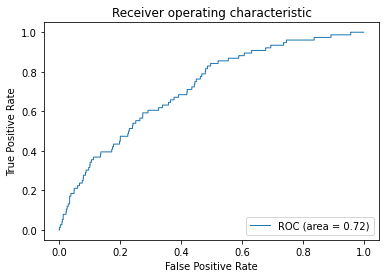

In [128]:
fpr, tpr, thresholds = roc_curve(y_valid, prob_result[2])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)' % roc_auc)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [129]:
m

array([[183453,     74],
       [    75,      1]], dtype=int64)

In [130]:
X_valid_x[0]

array([-0.11853889,  0.15953108,  0.59242696,  0.20967059, -0.69654097,
       -1.24766823, -0.96141074, -0.5083302 , -0.57096415, -0.57829914,
       -0.63166835, -0.50143326,  0.25524295, -0.23454024,  1.62109627])

In [131]:
df_train

,npi,total_drug_cost_sum,total_drug_cost_mean,total_drug_cost_max,total_claim_count_sum,total_claim_count_mean,total_claim_count_max,total_day_supply_sum,total_day_supply_mean,total_day_supply_max,...,DIAZEPAM_total_day_supply,ALLOPURINOL_total_drug_cost,ALLOPURINOL_total_day_supply,OXYCONTIN_total_drug_cost,OXYCONTIN_total_claim_count,OXYCONTIN_total_day_supply,drug_mean,drug_sum,drug_variance,Spec_Weight
593816,1003000126,4.092566,2.888972,3.969747,2.586587,1.399024,1.724276,3.906012,2.702700,3.184975,...,NaN,NaN,NaN,NaN,NaN,NaN,1.783389,2.476600,1.853793e+03,55
493584,1003000142,5.056408,3.714066,4.718552,3.266467,1.928954,2.530200,4.744840,3.402582,4.073205,...,NaN,NaN,NaN,NaN,NaN,NaN,3.622318,5.099339,9.146782e+07,4
761450,1003000167,2.183981,1.885785,1.958086,1.591065,1.301030,1.397940,2.198657,1.900367,2.089905,...,NaN,NaN,NaN,NaN,NaN,NaN,1.816573,2.510210,1.843332e+03,22
160806,1003000282,2.820195,2.519821,2.584467,1.740363,1.447158,1.518514,3.168203,2.867467,2.930949,...,NaN,276.87,852.0,NaN,NaN,NaN,2.752383,3.053028,1.653873e+05,21
178678,1003000407,4.866301,3.081325,4.090744,3.359266,1.585183,2.383815,4.622235,2.837526,3.374748,...,NaN,NaN,NaN,NaN,NaN,NaN,2.671752,4.085835,3.488178e+05,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220752,1790986925,5.026466,3.880391,4.925252,2.545307,1.414973,1.826075,4.053194,2.907565,3.416807,...,NaN,NaN,NaN,NaN,NaN,NaN,2.676065,3.754406,1.008120e+06,0
125004,1790986933,3.026864,2.329524,2.544490,2.311754,1.621176,1.903090,3.147985,2.450249,2.734800,...,NaN,NaN,NaN,NaN,NaN,NaN,2.319373,3.396642,2.910963e+04,1
54061,1790986941,2.279667,1.980912,2.016824,1.643453,1.352183,1.361728,2.451786,2.152288,2.152288,...,NaN,NaN,NaN,NaN,NaN,NaN,1.997736,2.693199,2.445938e+03,22
864274,1790986966,2.682452,2.207131,2.256694,1.838849,1.374137,1.477121,3.098990,2.622559,2.968950,...,NaN,NaN,NaN,NaN,NaN,NaN,2.032648,2.874279,7.066535e+03,5


In [132]:
X_valid_x[1]

array([-1.51659971, -1.2952079 ,  0.36949694, -1.40529175, -1.26771914,
       -0.47171971, -0.92246538, -1.37743858, -1.07968694, -1.23435305,
       -1.18777193, -1.28920355, -1.31745957, -0.32395815,  0.0772416 ])

In [133]:
y_pred = clf.predict(X_valid_x)

In [134]:
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [135]:
X_train[0]

array([ 0.17580909, -0.01527296, -0.77052688,  0.46608395,  0.20160072,
       -0.24072507, -0.1863803 ,  0.108827  , -0.22907934, -0.05881123,
       -0.12337776,  0.21832414,  1.21115731, -0.29965648,  1.62109627])

In [153]:
feature_importance = clfs_fited[2].feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

In [154]:
feature_importance[sorted_idx]


array([ 44.229221  ,  46.06615724,  46.32629575,  47.46613081,
        47.57418307,  50.14372325,  56.21753059,  57.81815599,
        58.63888811,  58.81457006,  61.99445656,  72.88707111,
        91.60169541,  92.11134126, 100.        ])

In [155]:
features = [numerical_features1[ix] for ix in sorted_idx]
bardata = {"name":features[::-1], "importance percent":feature_importance[sorted_idx][::-1]}

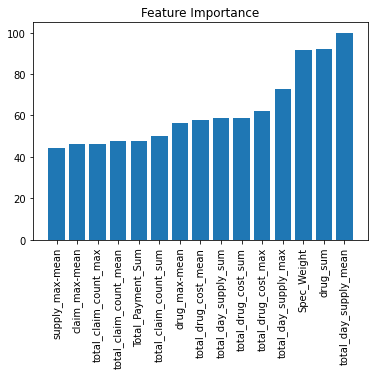

In [156]:
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X.shape[1]), feature_importance[sorted_idx])

# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), features, rotation=90)

# Show plot
plt.show()